In [32]:
from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [33]:
# ------------------------ Load and Visualize Data ------------------------ #

data = loadmat('ex4data1.mat')
X = data['X']  # (5000, 400)
y = data['y']  # (5000, 1)

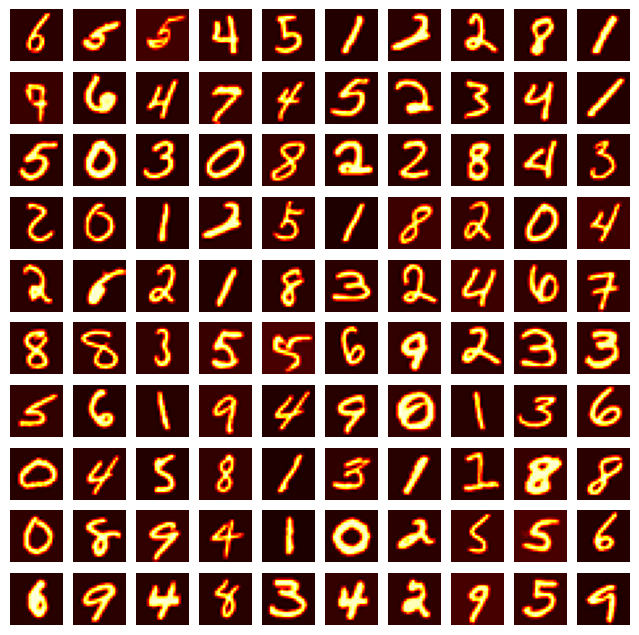

In [34]:
# Visualize 100 random digits
fig, axis = plt.subplots(10, 10, figsize=(8, 8))
for i in range(10):
    for j in range(10):
        idx = np.random.randint(0, 5000)
        axis[i, j].imshow(X[idx].reshape(20, 20, order='F'), cmap='hot')
        axis[i, j].axis('off')
plt.show()

In [35]:
# ------------------------ Load Pretrained Weights ------------------------ #

weights = loadmat('ex4weights.mat')
Theta1 = weights['Theta1']  # (25, 401)
Theta2 = weights['Theta2']  # (10, 26)

print("Theta1 shape:", Theta1.shape)
print("Theta2 shape:", Theta2.shape)

Theta1 shape: (25, 401)
Theta2 shape: (10, 26)


In [36]:
# ------------------------ Neural Network Functions ------------------------ #

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoidGradient(z):
    s = sigmoid(z)
    return s * (1 - s)

def predict(Theta1, Theta2, X):
    m = X.shape[0]
    X = np.hstack([np.ones((m, 1)), X])
    
    a2 = sigmoid(X @ Theta1.T)
    a2 = np.hstack([np.ones((a2.shape[0], 1)), a2])
    
    a3 = sigmoid(a2 @ Theta2.T)
    return np.argmax(a3, axis=1) + 1



In [37]:
# Prediction function for Neural Network
def predict(Theta1, Theta2, X):
    """Predict the label of an input given a trained neural network"""
    m = X.shape[0]
    
    # Add bias unit to input layer
    X = np.hstack((np.ones((m, 1)), X))
    
    # Forward propagation
    a1 = sigmoid(X @ Theta1.T)  # Hidden layer
    a1 = np.hstack((np.ones((m, 1)), a1))  # Add bias unit
    a2 = sigmoid(a1 @ Theta2.T)  # Output layer
    
    return np.argmax(a2, axis=1) + 1  # Return predicted labels (1-based index)

In [38]:

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1)
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1)

    m = X.shape[0]
    X = np.hstack([np.ones((m, 1)), X])

    y_matrix = np.zeros((m, num_labels))
    for i in range(num_labels):
        y_matrix[:, i] = (y.flatten() == (i + 1))

    # Forward Propagation
    z2 = X @ Theta1.T
    a2 = sigmoid(z2)
    a2 = np.hstack([np.ones((a2.shape[0], 1)), a2])
    
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)

    # Cost
    J = -np.sum(y_matrix * np.log(a3) + (1 - y_matrix) * np.log(1 - a3)) / m
    reg = Lambda / (2 * m) * (np.sum(np.square(Theta1[:, 1:])) + np.sum(np.square(Theta2[:, 1:])))
    J += reg

    # Backpropagation
    Delta1 = np.zeros(Theta1.shape)
    Delta2 = np.zeros(Theta2.shape)

    for t in range(m):
        a1t = X[t, :][np.newaxis, :]  # (1, 401)
        z2t = a1t @ Theta1.T          # (1, 25)
        a2t = sigmoid(z2t)
        a2t = np.hstack([np.ones((1, 1)), a2t])
        z3t = a2t @ Theta2.T
        a3t = sigmoid(z3t)

        d3 = a3t - y_matrix[t, :][np.newaxis, :]  # (1, 10)
        d2 = (d3 @ Theta2[:, 1:]) * sigmoidGradient(z2t)  # (1, 25)

        Delta1 += d2.T @ a1t
        Delta2 += d3.T @ a2t

    Theta1_grad = Delta1 / m
    Theta2_grad = Delta2 / m

    # Regularization
    Theta1_grad[:, 1:] += (Lambda / m) * Theta1[:, 1:]
    Theta2_grad[:, 1:] += (Lambda / m) * Theta2[:, 1:]

    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    return J, grad



In [39]:
# ------------------------ Random Weight Initialization ------------------------ #

def randInitializeWeights(L_in, L_out):
    epsilon_init = np.sqrt(6) / np.sqrt(L_in + L_out)
    return np.random.rand(L_out, L_in + 1) * 2 * epsilon_init - epsilon_init



In [ ]:
# ------------------------ Training Neural Network ------------------------ #

input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
Lambda = 1

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()])


def costFunction(p):
    return nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)


print("Training neural network...")

result = opt.fmin_cg(
    f=lambda p: costFunction(p)[0],
    x0=initial_nn_params,
    fprime=lambda p: costFunction(p)[1],
    maxiter=800,
    disp=True
)

# Extract trained Thetas
trained_Theta1 = result[:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1)
trained_Theta2 = result[hidden_layer_size * (input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1)


Training neural network...


In [ ]:
# ------------------------ Prediction & Accuracy ------------------------ #

pred = predict(trained_Theta1, trained_Theta2, X)
accuracy = np.mean(pred.flatten() == y.flatten()) * 100

print(f"Training Set Accuracy: {accuracy:.2f}%")